<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="45%" align="right" border="4">

# Parallel Valuation of Large Portfolios 

Derivatives (portfolio) valuation by Monte Carlo simulation is a **computationally demanding task**. For practical applications, when valuation speed plays an important role, **parallelization of both simulation and valuation tasks** might prove a useful strategy. DX Analytics has built in a basic parallelization option which allows the use of the Python `mulitprocessing` module. Depending on the tasks at hand this can already lead to significant speed-ups.

In [1]:
from dx import *
import time
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline

## Single Risk Factor

The example is based on a **single risk factor**, a `geometric_brownian_motion` object.

In [2]:
# constant short rate
r = constant_short_rate('r', 0.02)

In [3]:
# market environments
me_gbm = market_environment('gbm', dt.datetime(2015, 1, 1))

In [4]:
# geometric Brownian motion
me_gbm.add_constant('initial_value', 100.)
me_gbm.add_constant('volatility', 0.2) 
me_gbm.add_constant('currency', 'EUR')
me_gbm.add_constant('model', 'gbm')

In [5]:
# valuation environment
val_env = market_environment('val_env', dt.datetime(2015, 1, 1))
val_env.add_constant('paths', 25000)
val_env.add_constant('frequency', 'M')
val_env.add_curve('discount_curve', r)
val_env.add_constant('starting_date', dt.datetime(2015, 1, 1))
val_env.add_constant('final_date', dt.datetime(2015, 12, 31))

In [6]:
# add valuation environment to market environments
me_gbm.add_environment(val_env)

In [7]:
risk_factors = {'gbm' : me_gbm}

## American Put Option

We also model only a **single derivative instrument**.

In [8]:
gbm = geometric_brownian_motion('gbm_obj', me_gbm)

In [9]:
me_put = market_environment('put', dt.datetime(2015, 1, 1))
me_put.add_constant('maturity', dt.datetime(2015, 12, 31))
me_put.add_constant('strike', 40.)
me_put.add_constant('currency', 'EUR')
me_put.add_environment(val_env)

In [10]:
am_put = valuation_mcs_american_single(
                'am_put', mar_env=me_put, underlying=gbm,
                payoff_func='np.maximum(strike - instrument_values, 0)')

## Large Portfolio

However, the `derivatives_portfolio` object we compose consists of **100 derivatives positions**. Each option differes with respect to the strike.

In [11]:
positions = {}
strikes = np.linspace(80, 120, 100)
for i, strike in enumerate(strikes):
    positions[i] = derivatives_position(
                        name='am_put_pos_%s' % strike,
                        quantity=1,
                        underlyings=['gbm'],
                        mar_env=me_put,
                        otype='American single',
        payoff_func='np.maximum(%5.3f - instrument_values, 0)' % strike)

### Sequential Valuation

First, the derivatives portfolio with **sequential valuation**.

In [12]:
port_sequ = derivatives_portfolio(
                name='portfolio',
                positions=positions,
                val_env=val_env,
                risk_factors=risk_factors,
                correlations=None,
                parallel=False)  # sequential calculation

The call of the `get_values` method to **value all instruments** ...

In [13]:
t0 = time.time()
ress = port_sequ.get_values()
ts = time.time() - t0
print('Time in sec %.2f' % ts)

Total
 pos_value    839.234
dtype: float64
Time in sec 4.09


... and the **results visualized**.

Text(0,0.5,'option value estimates')

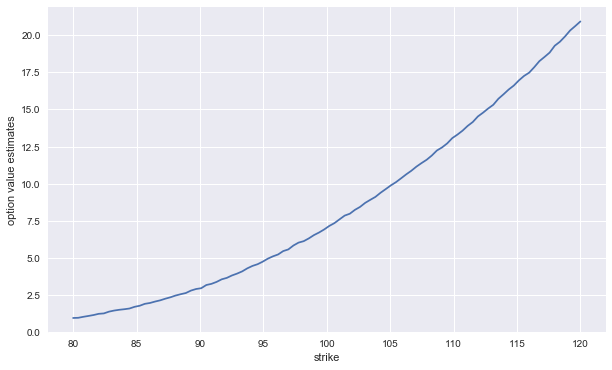

In [14]:
ress['strike'] = strikes
ress.set_index('strike')['value'].plot(figsize=(10, 6))
plt.ylabel('option value estimates')

### Parallel Valuation

Second, the derivatives portfolio with **parallel valuation**.

In [15]:
port_para = derivatives_portfolio(
                'portfolio',
                positions,
                val_env,
                risk_factors,
                correlations=None,
                parallel=True)  # parallel valuation

The call of the `get_values` method for the parall valuation case.

In [16]:
t0 = time.time()
resp = port_para.get_values()
  # parallel valuation with as many cores as available
tp = time.time() - t0
print('Time in sec %.2f' % tp)

Total
 pos_value    840.238
dtype: float64
Time in sec 5.36


Again, the **results visualized** (and compared to the sequential results).

Text(0,0.5,'option value estimates')

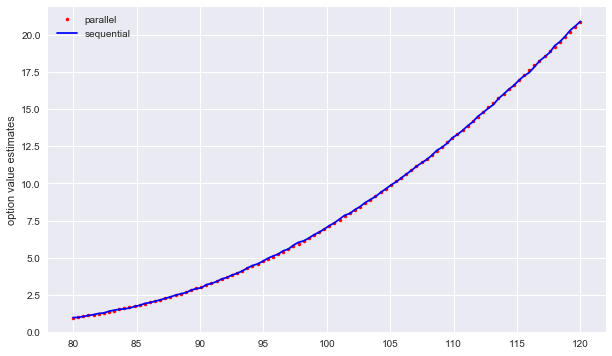

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(strikes, resp['value'].values, 'r.', label='parallel')
plt.plot(strikes, ress['value'].values, 'b', label='sequential')
plt.legend(loc=0)
plt.ylabel('option value estimates')

### Speed-up

The **realized speed-up** is of course dependend on the hardware used, and in particular the number of cores (threads) available.

In [18]:
ts / tp
  # speed-up factor
  # of course harware-dependent

0.7630898756144515

Text(0.5,1,'DX Analytics Portfolio Valuation')

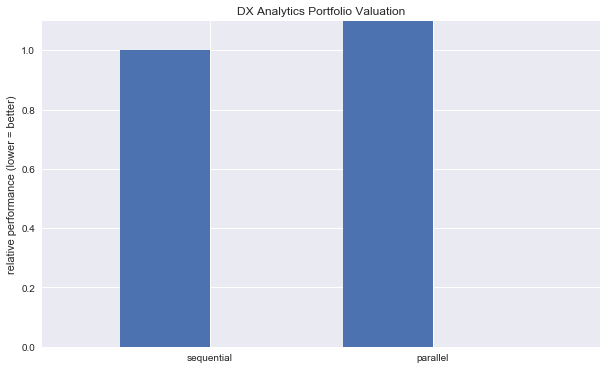

In [19]:
wi = 0.4
plt.figure(figsize=(10, 6))
plt.bar((1.5 - wi/2, 2.5 - wi/2), (ts/ts, tp/ts), width=wi)
plt.xticks((1.5, 2.5), ('sequential', 'parallel'))
plt.ylim(0, 1.1), plt.xlim(0.75, 3.25)
plt.ylabel('relative performance (lower = better)')
plt.title('DX Analytics Portfolio Valuation')

**Copyright, License & Disclaimer**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

DX Analytics (the "dx library") is licensed under the GNU Affero General Public License
version 3 or later (see [http://www.gnu.org/licenses/](http://www.gnu.org/licenses/)).

DX Analytics comes with no representations
or warranties, to the extent permitted by applicable law.


<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

[http://tpq.io](http://tpq.io) | [team@tpq.io](mailto:team@tpq.io) | [http://twitter.com/dyjh](http://twitter.com/dyjh)

**Quant Platform** |
[http://quant-platform.com](http://quant-platform.com)

**Derivatives Analytics with Python (Wiley Finance)** |
[http://derivatives-analytics-with-python.com](http://derivatives-analytics-with-python.com)

**Python for Finance (O'Reilly)** |
[http://python-for-finance.com](http://python-for-finance.com)